## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
import skvideo.io
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [98]:
import calibration
import image_threshold
import perspetive_transform
import find_lane_pixels
import measure_curvature
import utils

In [3]:
from moviepy.editor import VideoFileClip

In [4]:
from PIL import Image, ImageFont, ImageDraw

## perspective transform

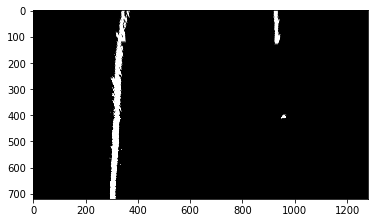

In [1262]:
# image = mpimg.imread('./test_images/test1.jpg')
image = mpimg.imread('./frame.jpg')

image = calibration.calibrate(image)

s_thresh=(100, 255)
l_thresh=(180, 255)

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 255

l_binary = np.zeros_like(l_channel)
l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 255

img = np.bitwise_or(l_binary, s_binary)
color_binary = img

# image = image_threshold.convert_thresh(image)

mask = np.zeros_like(color_binary)
roi_corners = np.array([[(150,720), (500,500), (900, 500), (1200,720)]], dtype=np.int32)
ignore_mask_color = (255,)
cv2.fillPoly(mask, roi_corners, ignore_mask_color)
masked_image = cv2.bitwise_and(color_binary, mask) / 255.0
    

# masked_image = perspetive_transform.apply_mask(image)
warped, _ = perspetive_transform.apply_perspective_transform(masked_image)

kernel = np.ones((11, 11), np.uint8)
closing = cv2.morphologyEx(warped.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

plt.imshow(warped, cmap='gray')

In [1263]:
plt.imsave('./image_warped.jpg', warped, cmap='gray')

In [1258]:
plt.imsave('./image_thresh.jpg', color_binary, cmap='gray')

In [944]:
closing.shape

(720, 1280)

In [979]:
closing.shape

(720, 1280)

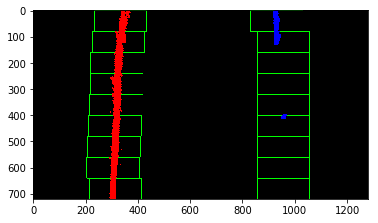

In [1264]:
out_img, left_fit, right_fit = find_lane_pixels.fit_polynomial(warped)

plt.imshow(out_img)

In [1265]:
plt.imsave('./lane_detected.jpg', out_img, cmap='gray')

In [863]:
out_img[out_img>0].shape

(45020,)

In [1219]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_fitx, right_fitx = find_lane_pixels.search_around_poly(warped, left_fit, right_fit)

# View your output
# plt.imshow(result)

In [1221]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature.measure_curvature_real(left_fitx, right_fitx)

print(left_curverad, 'm', right_curverad, 'm')

2302.5054909592623 m 1244.7032879295593 m


In [364]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
        self.last_point = None

In [365]:
fontsize = 30
font = ImageFont.truetype("./Caviar-Dreams/CaviarDreams.ttf", fontsize)

In [366]:
first = True
left_line = None
right_line = None
mid_point = None
count = 0
    
def init():
    global first
    global left_line
    global right_line
    global mid_point
    global count
    first = True
    left_line = Line()
    right_line = Line()
    mid_point = None
    count = 0

In [1252]:
def process_frame(frame):
    try:
        global first
        global left_line
        global right_line
        
        global font
        global fontsize
        global mid_point
        global count
        
        
        image = calibration.calibrate(frame)

        image = image_threshold.convert_thresh(image)

        h , w = image.shape

        masked_image = perspetive_transform.apply_mask(image)
        warped, M = perspetive_transform.apply_perspective_transform(masked_image)
        
        kernel = np.ones((5, 5), np.uint8)
        warped = cv2.morphologyEx(warped.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        
        left_fit = None
        right_fit = None
        
        try:
            result, left_fit, right_fit = find_lane_pixels.fit_polynomial(warped)
        except:
            pass
        
        if left_fit is None or right_fit is None:
#             print("Not detected")
            left_fit = left_line.current_fit
            right_fit = right_line.current_fit
            
            left_line.detected = False
            right_line.detected = False
            
#             left_line.diffs = np.array([0,0,0], dtype='float')
#             right_line.diffs = np.array([0,0,0], dtype='float')
        else:
            
#             left_line.diffs = left_line.current_fit - left_fit
#             right_line.diffs = right_line.current_fit - right_fit 
            
            
            left_line.detected = True
            right_line.detected = True
            
        good_fit = True 
            
#         print(right_fit, right_line.current_fit)
        if left_line.detected:
            left_fitx, right_fitx = find_lane_pixels.search_around_poly(warped, left_fit, right_fit)
        
#             left_line.allx = left_fitx
#             right_line.allx = right_fitx
        
#             left_last_point = left_fit[0] * (500**2) + left_fit[1] * 500 + left_fit[2];
#             right_last_point = right_fit[0] * (500**2) + right_fit[1] * 500 + right_fit[2];

            left_curverad_temp, right_curverad_temp = measure_curvature.measure_curvature_real(left_fitx, right_fitx)
            
#             if (left_curverad_temp < 500) or (right_curverad_temp < 500):
#                 good_fit = False

#             print(left_last_point, right_last_point)
#             print(left_line.last_point, right_line.last_point)
        
#             print(left_curverad_temp, right_curverad_temp)
            
#             poly_ratio = abs(left_fit[0] / right_fit[0])
        
# #             print(poly_ratio)
        
#             if (poly_ratio < 1 and poly_ratio<0.7) or (poly_ratio > 1 and 1/poly_ratio<0.7):
# #                 print('kkk')
#                 good_fit = False

            if left_curverad_temp < 100 or right_curverad_temp < 100:
#                 print(right_fit)
                good_fit = False

            if abs(left_fit[0]) > 1e-03 or abs(right_fit[0]) > 1e-03\
                or len(left_fitx[left_fitx>500]) > 150\
                or len(right_fitx[right_fitx<850]) > 150:
                good_fit = False
        
        if (good_fit and left_line.detected) or len(left_line.best_fit) == 0:
#             print('enter')
            left_line.current_fit = left_fit
            right_line.current_fit = right_fit
            
            left_line.best_fit.append(left_fit)
            right_line.best_fit.append(right_fit)
            
            if len(left_line.best_fit) > 10:
                left_line.best_fit = left_line.best_fit[1:]
                right_line.best_fit = right_line.best_fit[1:]
                
            left_last_n = np.average(left_line.best_fit, axis=0)
            right_last_n = np.average(right_line.best_fit, axis=0)

#             if left_curverad_temp < 100 or right_curverad_temp < 100:
#                 print(right_line.best_fit)
        
        
#         if left_line.detected:    
            left_fitx_f, right_fitx_f = find_lane_pixels.search_around_poly(warped, left_last_n, right_last_n)
            
            left_line.recent_xfitted.append(left_fitx_f)
            right_line.recent_xfitted.append(right_fitx_f)
        
            if len(left_line.recent_xfitted) > 10:
                left_line.recent_xfitted = left_line.recent_xfitted[1:]
                right_line.recent_xfitted = right_line.recent_xfitted[1:]



        left_curverad, right_curverad = measure_curvature.measure_curvature_real(np.average(left_line.recent_xfitted, axis=0),\
                                                                           np.average(right_line.recent_xfitted, axis=0))
        
#         print(left_curverad, right_curverad)
        
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, h-1, h)
        
        pts_left = np.array([np.transpose(np.vstack([np.average(left_line.recent_xfitted, axis=0), ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([np.average(right_line.recent_xfitted, axis=0), ploty])))])
        
        pts = np.hstack((pts_left, pts_right))
        
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (image.shape[1], image.shape[0])).astype(np.float64)

        result = cv2.addWeighted(frame[..., ::-1]/255, 1, newwarp/255, 0.3, 0)
        
        result = (np.clip(result, 0, 1) * 255).astype(np.uint8)[..., ::-1]

        img = Image.fromarray(result)
        
        draw = ImageDraw.Draw(img)
        draw.text((200,70), "Radius of curvature : Left: " + str(round(left_curverad, 1)) + " m Right: " + str(round(right_curverad, 1)),\
                  (255,255,255), font=font)
        draw.text((200,150), "Vehicle is " + str(utils.get_shift(np.average(left_line.recent_xfitted, axis=0),\
                                                                 np.average(right_line.recent_xfitted, axis=0))) + " left of center",\
                  (255,255,255), font=font)
        draw = ImageDraw.Draw(img)
        result = np.array(img)
#         result = np.dstack(( image, image, image))
    except Exception as e:
        print(e)
        result = np.ones_like(frame)
    
    return result
    
    

In [462]:
init()

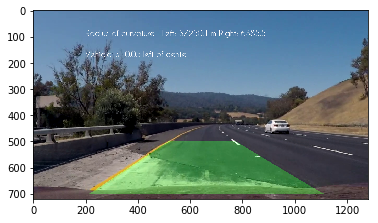

In [1253]:
cap = cv2.VideoCapture('./project_video.mp4')

n = 0
x = 617

while(cap.isOpened()):
    ret, frame = cap.read()
    n += 1
    if n < x:
        continue

    
    result = process_frame(frame)

#     print(result.shape)
    plt.imshow(result[..., ::-1])
#     plt.imsave('frame.jpg', frame[..., ::-1])

    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if n >= x:
        break

In [992]:
np.average(right_line.best_fit, axis=0)

array([-1.35864901e-04,  2.14085145e-01,  9.10274818e+02])

In [1067]:
right_line.best_fit

[array([9.03753473e-05, 2.08767915e-02, 9.27206217e+02]),
 array([8.18374335e-05, 1.37403731e-02, 9.32380071e+02]),
 array([ 9.40087310e-05, -4.25025276e-03,  9.36457390e+02]),
 array([-1.60621455e-05,  5.58602404e-02,  9.34896290e+02]),
 array([3.50025269e-05, 1.76834683e-02, 9.46369016e+02]),
 array([ 5.71889325e-05, -7.62880181e-03,  9.55192489e+02]),
 array([ 5.68723632e-05, -2.65839846e-03,  9.49830500e+02]),
 array([-5.72417519e-04,  5.76269180e-01,  8.41964445e+02]),
 array([-1.61223230e-05,  1.06315602e-01,  9.31833851e+02]),
 array([-1.61223230e-05,  1.06315602e-01,  9.31833851e+02]),
 array([1.20117838e-04, 2.88953699e-02, 9.27312693e+02]),
 array([1.94773480e-05, 7.80901913e-02, 9.27016447e+02]),
 array([-5.72417519e-04,  5.76269180e-01,  8.41964445e+02]),
 array([-1.61223230e-05,  1.06315602e-01,  9.31833851e+02]),
 array([1.20117838e-04, 2.88953699e-02, 9.27312693e+02])]

In [1068]:
np.average(right_line.best_fit, axis=0)

array([-3.56177196e-05,  1.13399301e-01,  9.22893617e+02])

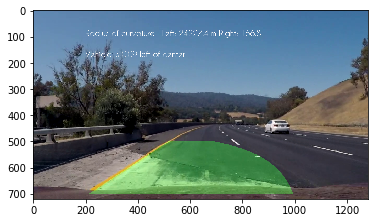

In [1214]:
cap = cv2.VideoCapture('./project_video.mp4')

n = 0
x = 617

while(cap.isOpened()):
    ret, frame = cap.read()
    n += 1
    if n < x:
        continue

    
    result = process_frame(frame)

#     print(result.shape)
    plt.imshow(result[..., ::-1])

    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if n >= x:
        break

In [628]:
right_line.current_fit

array([ 3.07123066e-04, -3.16539611e-01,  1.06870246e+03])

In [629]:
right_line.best_fit

[array([5.03097759e-05, 2.93637706e-02, 9.60510109e+02]),
 array([7.70537192e-06, 5.65143730e-02, 9.53662055e+02]),
 array([ 8.05098561e-05, -2.35718261e-03,  9.64906945e+02]),
 array([3.29564661e-05, 3.05405151e-02, 9.63621745e+02]),
 array([ 3.07123066e-04, -3.16539611e-01,  1.06870246e+03])]

In [466]:
abs(-6.886518397407995e-06 + 6.834006241932763e-05) > 1e-6

True

In [410]:
np.average(left_line.best_fit, axis=0)

array([ 1.53286398e-06, -3.63920654e-02,  3.63438468e+02])

In [411]:
np.average(right_line.best_fit, axis=0)

array([4.06764890e-05, 4.34908317e-02, 9.64860549e+02])

In [ ]:
359.20742760670214 1007.2558227332081
357.2918477750251 915.77956723887



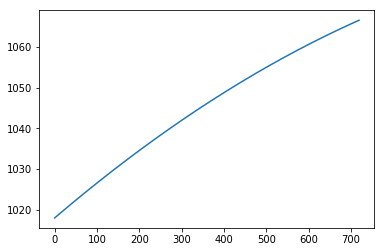

In [1135]:
plt.plot(right_line.recent_xfitted[0])

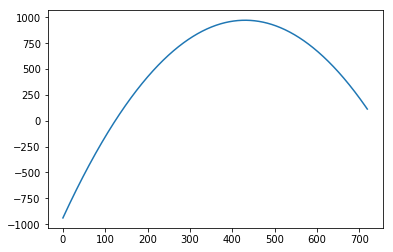

In [1248]:
plt.plot(np.average(right_line.recent_xfitted[9:], axis=0))

In [1212]:
temp_fit = right_line.best_fit[-1]
750 * temp_fit[0]**2 + 750 * temp_fit[1] + temp_fit[2]

1010.6985175107855

In [1206]:
right_line.best_fit

[array([3.29088168e-05, 2.12674477e-02, 1.01315663e+03]),
 array([-4.71595937e-05,  1.42365006e-01,  9.36306835e+02]),
 array([4.38186403e-05, 3.74364384e-02, 9.71142803e+02]),
 array([1.93547744e-05, 4.44642704e-02, 9.78571493e+02]),
 array([-5.42839711e-05,  1.36935885e-01,  9.52302580e+02]),
 array([1.58776678e-05, 7.65574268e-02, 9.50113246e+02]),
 array([1.32040524e-05, 7.42781532e-02, 9.53264574e+02]),
 array([1.80724709e-05, 6.46176580e-02, 9.55440654e+02]),
 array([-2.59498747e-05,  8.30533764e-02,  9.64807710e+02]),
 array([-1.54047026e-05,  1.08395632e-01,  9.29401793e+02])]

In [1205]:
right_line.current_fit

array([-1.54047026e-05,  1.08395632e-01,  9.29401793e+02])

In [1255]:
white_output = './out_sat_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
init()
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./out_sat_2.mp4
[MoviePy] Writing video ./out_sat_2.mp4



 12%|█▏        | 152/1261 [02:31<18:27,  1.00it/s]


 24%|██▍       | 303/1261 [04:54<15:32,  1.03it/s]


 36%|███▌      | 454/1261 [07:18<12:59,  1.04it/s]


 48%|████▊     | 605/1261 [09:42<10:31,  1.04it/s]


 60%|█████▉    | 756/1261 [12:05<08:04,  1.04it/s]


 72%|███████▏  | 907/1261 [14:29<05:39,  1.04it/s]


 84%|████████▍ | 1057/1261 [16:53<03:15,  1.04it/s]


 96%|█████████▌| 1205/1261 [19:19<00:53,  1.04it/s]


100%|█████████▉| 1260/1261 [20:15<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_sat_2.mp4 

CPU times: user 32min 49s, sys: 1min 54s, total: 34min 43s
Wall time: 20min 16s
